# Train the keras models

## Load the data

In [1]:
import pandas as pd
import numpy as np
import setGPU
import psutil
import importlib
import fit_handler

setGPU: Setting GPU to: 0


Using TensorFlow backend.


float32


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [1]:
import imblearn

Using TensorFlow backend.


In [6]:
mem = psutil.virtual_memory()

In [8]:
mem[2]

3.4

In [2]:
from plotting import plot

In [3]:
from models import baseline_model

In [4]:
from models import nlp_model

In [5]:
from data_loader import input_batch_generator
from data_loader import index

In [48]:
importlib.reload(fit_handler)

<module 'fit_handler' from '/nfshome/llayer/AIErrorLogAnalysis/training/fit_handler.py'>

In [7]:
psutil.cpu_percent(), psutil.virtual_memory()

(1.7,
 svmem(total=101089452032, available=97835724800, percent=3.2, used=2708344832, free=52868313088, active=29047480320, inactive=16017190912, buffers=106041344, cached=45406752768, shared=36364288, slab=1434251264))

In [49]:
path = '/nfshome/llayer/AIErrorLogAnalysis/data/input_NOMINAL.h5'
actionshist, codes, sites = fit_handler.load_data(path, msg_only=True, sample=True)

0    31839
1     1747
Name: label, dtype: int64
After sampling: Minority class 1747 Majority class 5241


In [50]:
actionshist.head()

,task_name,label,error,site,site_state,count,msg_encoded,exit_code,error_type,avg
38,/areinsvo_task_HIN-pPb816Spring16GS-00047__v1_...,1,"[-1, -1, -1, -1, -1, 99303, -1, -1, -1, -1, -1...","[T2_ES_IFCA, T2_IT_Pisa, T2_PK_NCP, T2_RU_SINP...","[bad, good, bad, bad, good, good, good, bad, g...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
39,/areinsvo_task_HIN-pPb816Spring16GS-00048__v1_...,1,"[-1, -1, -1, 99303, -1, -1, -1, -1, -1, -1, -1...","[T2_IN_TIFR, T3_GR_IASA_HG, T3_US_UCD, T2_BE_I...","[good, bad, bad, good, bad, bad, good, bad, ba...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
40,/areinsvo_task_HIN-pPb816Spring16GS-00050__v1_...,1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[T2_RU_PNPI, T3_UK_ScotGrid_GLA, T3_US_TAMU, T...","[bad, bad, bad, good, bad, bad, bad, good, goo...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
41,/areinsvo_task_HIN-pPb816Spring16GS-00050__v1_...,1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[T3_US_UCD, T3_CN_PKU, T3_US_TAMU, T3_GR_IASA_...","[bad, bad, bad, bad, good, bad, good, good, go...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1226,/mcremone_task_EXO-RunIISummer15wmLHEGS-05038_...,1,"[71104, -1, 92, -1]","[Unknown, T1_DE_KIT_Disk, T1_IT_CNAF, T1_IT_CN...","[bad, bad, bad, bad]","[1, 1, 1, 1]","[nan, nan, [34, 11, 9, 36, 147, 33, 24, 2, 68,...","[nan, nan, 8028.0, nan]","[nan, nan, Fatal Exception, nan]","[nan, nan, [-0.8222899436950684, 0.81316602230..."


In [10]:
psutil.cpu_percent(), psutil.virtual_memory()

(3.3,
 svmem(total=101089452032, available=96091189248, percent=4.9, used=4469723136, free=67459616768, active=20523405312, inactive=10697121792, buffers=109608960, cached=29050503168, shared=19484672, slab=696438784))

In [18]:
#sites_index, codes_index = index.to_index(list(sites['site']), list(codes['error']))
sites_index, codes_index = index.to_index(list(sites_msg['sites_msg']), list(codes_msg['errors_msg']))

In [140]:
# Prune without counts
#codes_index, sites_index = index.prune_to_index(codes, sites, only_unknown = True)

In [19]:
padding_size = 200
dim_errors = len(codes_index)
dim_sites = len(sites_index)
max_msg = 5

## Train the simple nlp models

In [20]:
importlib.reload(input_batch_generator)
padding_size = 50
batch_size = 100
generator = input_batch_generator.InputBatchGenerator(actionshist, 'label', codes_index, sites_index,
                                                      padding_size, batch_size = batch_size, 
                                                      averaged=True, first_only=True, count_msg = False)

In [22]:
test = generator.msg_batch(0, 100)
test.shape

(100, 67, 77, 50)

In [49]:
from models import w2v_model

In [45]:
embedding_dim = 50

In [288]:
model_w2v = w2v_model.SimpleAverage(2, dim_errors, dim_sites, embedding_dim)

In [289]:
model_w2v.create_model(**model_w2v.model_params)

Tensor("input_44:0", shape=(?, 50), dtype=float32)
Tensor("dense_165/Relu:0", shape=(?, 35), dtype=float32)
Tensor("input_45:0", shape=(?, 77, 153, 2), dtype=float32)
Tensor("dropout_138/cond/Merge:0", shape=(?, 35), dtype=float32)


In [148]:
importlib.reload(w2v_model)
model_w2v = w2v_model.W2V(2, dim_errors, dim_sites, embedding_dim)

In [149]:
model_w2v.create_model(**model_w2v.model_params)

In [150]:
model_w2v.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 77, 153, 50)       0         
_________________________________________________________________
reshape_74 (Reshape)         (None, 77, 7650)          0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 77, 20)            153020    
_________________________________________________________________
flatten_35 (Flatten)         (None, 1540)              0         
_________________________________________________________________
dense_300 (Dense)            (None, 35)                53935     
_________________________________________________________________
dropout_223 (Dropout)        (None, 35)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 35)                1260      
__________

In [127]:
# Early stopping
import keras
from sklearn.metrics import roc_auc_score

class EarlyStoppingRoc(keras.callbacks.Callback):

    def __init__(self, patience, mode='min'):

        super().__init__()
        self.patience = patience
        self.best_score = -np.inf if mode == 'max' else np.inf
        self.wait = 0
        self.is_better = np.greater if mode == 'max' else np.less


    def on_epoch_end(self, epoch, logs={}):

        print( self.validation_data[1].shape )
        
        val_predict = (np.asarray(self.model.predict([self.validation_data[0], self.validation_data[1]])))
        val_predict_max = np.argmax(val_predict, axis=-1)
        val_targ = self.validation_data[2]
        score = roc_auc_score(val_targ, val_predict)
        print
        print( score )
        print
        if self.is_better(score, self.best_score):
            self.wait = 0
            self.best_score = score
        else:
            self.wait += 1
        if self.wait > self.patience:
            self.model.stop_training = True

In [128]:
class Metrics(keras.callbacks.Callback):
    
    def __init__(self, val_gen):
        super().__init__()
        self.validation_gen = val_gen    
        
    def on_epoch_end(self, epoch, logs={}):
        
        X_test_batches = []
        y_test_batches = []
        for X,y in self.validation_gen.gen_batches():
            X_test_batches.append(np.asarray(self.model.predict(X)))
            y_test_batches.append(y)
                        
                        
        X_test = np.concatenate(X_test_batches)
        y_test = np.concatenate(y_test_batches)
                
        y = y_test[0:X_test.shape[0]]
        score = roc_auc_score(y, X_test)
        print
        print( score )
        print        
        
        return

In [141]:
from sklearn.model_selection import train_test_split
importlib.reload(w2v_model)
importlib.reload(input_batch_generator)



def train(X, test_size=0.33):
    #model_w2v = w2v_model.SimpleAverage(2, dim_errors, dim_sites, embedding_dim)
    embedding_dim = 50
    model_w2v = w2v_model.W2V(2, dim_errors, dim_sites, embedding_dim)
    model_w2v.create_model(**model_w2v.model_params)
    batch_size = 100
    #es = EarlyStoppingRoc(mode='max', patience=5)
    train, test = train_test_split(X, test_size = test_size)
    generator_train = input_batch_generator.InputBatchGenerator(train, 'label', codes_index, sites_index,
                                                      embedding_dim, batch_size = batch_size, 
                                                      averaged=True, first_only=True, count_msg = False)
    #generator = input_batch_generator.InputBatchGenerator(train, 'label', codes_index, sites_index, embeddind_dim)   
    #counts_train = generator.get_counts_matrix()
    #w2v_train = np.array(list(train['avg']))
    generator_test = input_batch_generator.InputBatchGenerator(test, 'label', codes_index, sites_index,
                                                      embedding_dim, batch_size = batch_size, 
                                                      averaged=True, first_only=True, count_msg = False)    
    #counts_test = generator.get_counts_matrix()
    #w2v_test = np.array(list(test['avg']))
    #print(counts_train[0].shape, w2v_train.shape)
    #print(counts_test[0].shape, w2v_test.shape)
    
    #X_train = [counts_train[0] , w2v_train]
    #X_test = [counts_test[0] , w2v_test]
    #y_train = counts_train[1]
    #y_test = counts_test[1]
    
    #model_w2v.model.fit( X_train, y_train, validation_data = (X_test, y_test), batch_size = 2370, epochs = 20,
    #                   callbacks = [es]) 
    
    steps_per_epoch = int(len(train) / batch_size)
    steps_val = int(len(test) / batch_size)
    m = Metrics(generator_test)
    model_w2v.model.fit_generator(generator = generator_train.gen_inf_batches(), steps_per_epoch = steps_per_epoch,
                                 callbacks = [m], validation_data = generator_test.gen_inf_batches(), epochs = 20, 
                                 validation_steps = steps_val)
    
train(actionshist)
psutil.cpu_percent(), psutil.virtual_memory()

/nfshome/llayer/AIErrorLogAnalysis/training/data_loader/input_batch_generator.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.frame['unique_index'] = self.frame.reset_index().index


Epoch 1/20


ValueError: Error when checking input: expected input_76 to have shape (77, 153, 50) but got array with shape (77, 81, 50)

## Train the count models

In [28]:
importlib.reload(fit_handler)

<module 'fit_handler' from '/nfshome/llayer/AIErrorLogAnalysis/training/fit_handler.py'>

In [29]:
importlib.reload(input_batch_generator)
padding_size = 200
generator = input_batch_generator.InputBatchGenerator(actionshist, 'label', codes_index, sites_index,
                                                      padding_size)

In [30]:
X, y = generator.get_counts_matrix()

In [31]:
X.shape

(33586, 77, 153, 2)

In [32]:
psutil.cpu_percent(), psutil.virtual_memory()

(1.0,
 svmem(total=101089452032, available=95310278656, percent=5.7, used=5183545344, free=12556406784, active=21971963904, inactive=63444500480, buffers=213016576, cached=83136483328, shared=86691840, slab=1378877440))

In [73]:
handler = fit_handler.FitHandler()

In [29]:
ff = baseline_model.FF(2, dim_errors, dim_sites)

In [76]:
cv = handler.kfold_val(ff.model_params, X, y, kfold_splits = 3, batch_size = 2370, max_epochs = 200, optimize = False)

4.4 svmem(total=101089452032, available=80699760640, percent=20.2, used=19819245568, free=19038736384, active=35384201216, inactive=42300755968, buffers=463794176, cached=61767675904, shared=61505536, slab=2501304320)
Train on 22390 samples, validate on 11196 samples
Epoch 1/200
22390/22390 [==============================] - 10s 445us/step - loss: 0.7233 - acc: 0.8686 - val_loss: 0.4960 - val_acc: 0.9487
0
0.5123153444596286
(0.06717972868461328, 0.07118601294730793)
Epoch 2/200
22390/22390 [==============================] - 10s 425us/step - loss: 0.4149 - acc: 0.9476 - val_loss: 0.3313 - val_acc: 0.9487
0
0.6280099090901337
(0.0832746443472585, 0.08433252594141555)
Epoch 3/200
22390/22390 [==============================] - 9s 412us/step - loss: 0.3000 - acc: 0.9476 - val_loss: 0.2724 - val_acc: 0.9487
0
0.6884662494579327
(0.09437242069994874, 0.09499773133705841)
Epoch 4/200
22390/22390 [==============================] - 10s 434us/step - loss: 0.2676 - acc: 0.9476 - val_loss: 0.2542 

0
0.7494717932606717
(0.22142124751407843, 0.22299932784374144)
Epoch 21/200
22391/22391 [==============================] - 12s 518us/step - loss: 0.1864 - acc: 0.9518 - val_loss: 0.2347 - val_acc: 0.9476
0
0.7561909825434803
(0.241260327737362, 0.24276236324964595)
Epoch 22/200
22391/22391 [==============================] - 13s 567us/step - loss: 0.1863 - acc: 0.9521 - val_loss: 0.2321 - val_acc: 0.9468
0
0.7624696907449029
(0.24563885109206984, 0.24723577042516642)
Epoch 23/200
22391/22391 [==============================] - 11s 506us/step - loss: 0.1829 - acc: 0.9528 - val_loss: 0.2381 - val_acc: 0.9456
0
0.7550100292418859
(0.23019115047517996, 0.2319155178188784)
Epoch 24/200
22391/22391 [==============================] - 12s 544us/step - loss: 0.1815 - acc: 0.9538 - val_loss: 0.2429 - val_acc: 0.9438
0
0.7452051362607441
(0.22241712790286816, 0.2241739670888918)
8.7 svmem(total=101089452032, available=72205336576, percent=28.6, used=28313673728, free=10409758720, active=4386960179

In [34]:
psutil.cpu_percent(), psutil.virtual_memory()

(4.4,
 svmem(total=101089452032, available=70893699072, percent=29.9, used=29625159680, free=9559494656, active=39035039744, inactive=48112922624, buffers=463597568, cached=61441200128, shared=61472768, slab=2498093056))

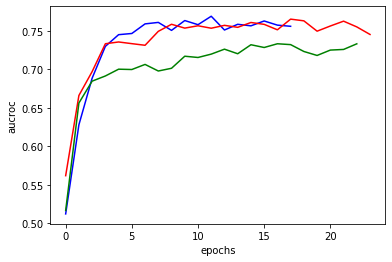

In [103]:
importlib.reload(plot)
plot.plot_metric(cv['es'], 'aucroc')

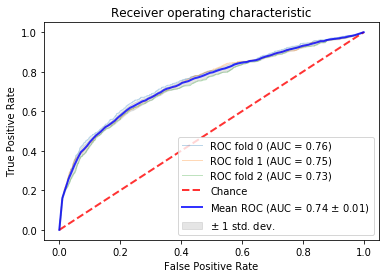

In [97]:
plot.plot_cv_roc_curve(cv['aucs'], cv['tprs'], cv['fprs'])

In [ ]:
result = handler.find_optimal_parameters( ff, X, y, batch_size = 1000, num_calls = 20 )

In [ ]:
result[0].to_hdf('skopt_baseline_prune_sites_errors_neg.h5', 'frame')

In [ ]:
prior_names = [a for a in ff.model_params.keys()]
prior_names.append('batch_size')
param_opt = handler.get_results(result[0], prior_names)

In [99]:
skopt_files = ['skopt_baseline.h5', 'skopt_baseline_prune_neg.h5', 'skopt_baseline_prune_sites_errors.h5',
             'skopt_baseline_prune_sites_errors_neg.h5', 'skopt_baseline_prune_sites.h5', 'skopt_baseline_tier.h5']
skopt_titles = ['standard', 'prune_neg', 'prune_sites_error', 'pruned_sites_errors_neg', 'prune_sites', 'prune_tier']

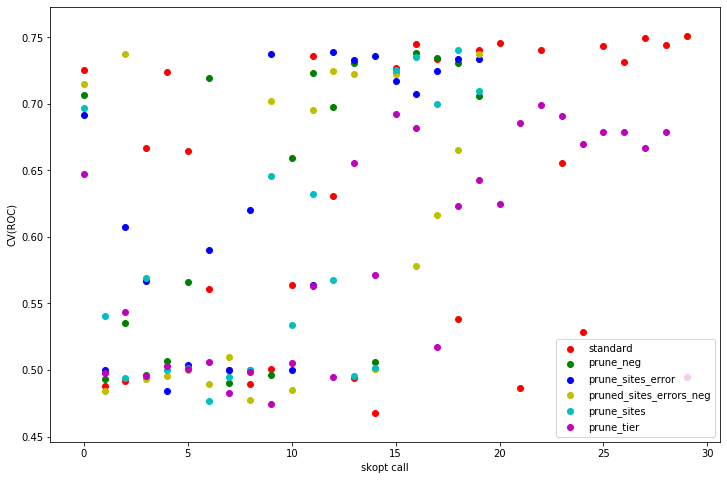

In [108]:
importlib.reload(plot)
plot.plot_skopt_results(skopt_files, skopt_titles)

## Train the error message models

In [34]:
importlib.reload(nlp_model)

<module 'models.nlp_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/models/nlp_model.py'>

In [35]:
importlib.reload(input_batch_generator)
padding_size = 200
batch_size = 100
generator = input_batch_generator.InputBatchGenerator(actionshist, 'label', codes_index, sites_index,
                                                      padding_size, batch_size = batch_size)

In [37]:
test = generator.msg_batch(0, 100)
test[0].shape, test[1].shape

((100, 77, 153, 5, 200), (100, 77, 153, 2))

In [39]:
%timeit generator.msg_batch(0, 100)

34 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
model = nlp_model.NLP_Model(2, dim_errors, dim_sites, padding_size, max_msg, debug=True)

In [26]:
model.create_model(**model.model_params)

W0813 01:15:13.035640 139849874995008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 01:15:13.091596 139849874995008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 01:15:13.112013 139849874995008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 01:15:13.120683 139849874995008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 01:15:13.121259 1398498749

Tensor("input_2:0", shape=(?, 77, 153, 5, 200), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 58905, 200), dtype=float32)


W0813 01:15:18.158759 139849874995008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0813 01:15:18.167778 139849874995008 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("time_distributed_1/Reshape_1:0", shape=(?, 58905, 10), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 11781, 5, 10), dtype=float32)
Tensor("lambda_1/Mean:0", shape=(?, 11781, 10), dtype=float32)
Tensor("reshape_3/Reshape:0", shape=(?, 77, 153, 10), dtype=float32)
Tensor("input_1:0", shape=(?, 77, 153, 2), dtype=float32)
Tensor("concatenate_1/concat:0", shape=(?, 77, 153, 12), dtype=float32)
Tensor("time_distributed_2/Reshape_1:0", shape=(?, 77, 10), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 10), dtype=float32)
Tensor("dense_3/Sigmoid:0", shape=(?, 1), dtype=float32)


In [28]:
model.print_summary()

Word encoder model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 50)           1633300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
Total params: 1,635,740
Trainable params: 2,440
Non-trainable params: 1,633,300
_________________________________________________________________


Site encoder model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 153, 12)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1836)              0         
_____________________

In [17]:
steps_per_epoch = int(len(actionshist) / batch_size)

In [18]:
steps_per_epoch

33586

In [19]:
psutil.cpu_percent(), psutil.virtual_memory()

(4.8,
 svmem(total=101089452032, available=93577891840, percent=7.4, used=6936924160, free=9593868288, active=22818115584, inactive=63833616384, buffers=462155776, cached=84096503808, shared=65699840, slab=3015208960))

In [ ]:
psutil.

In [20]:
model.model.fit_generator(generator = generator.gen_batches(), steps_per_epoch = steps_per_epoch)

Epoch 1/1
   36/33586 [..............................] - ETA: 11:44:31 - loss: 0.0096

KeyboardInterrupt: 